In [1]:
import xarray as xr
from pathlib import Path
import rioxarray
from rasterio.enums import Resampling
import pandas as pd

In [1]:
time_series_folder = '../output_folder/completeness_analysis/'
nasa_time_series_name = '2021_SuomiNPP_nasa_time_series_fsc.nc'
meteofrance_time_series_name = '2021_meteofrance_time_series.nc'

meteofrance_time_series_path= Path(f"{time_series_folder}").joinpath(meteofrance_time_series_name)
nasa_time_series_path= Path(f"{time_series_folder}").joinpath(nasa_time_series_name)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)          # No wrapping based on display width

NameError: name 'Path' is not defined

In [10]:
import numpy as np
from typing import Tuple, Dict
import pandas as pd
import rasterio
meteofrance_classes = {'snow_cover' : range(1,201), 'no_snow': (0,), 'clouds': (255,), 'forest_without_snow': (215,), 'forest_with_snow': (210,), 'water': (220,), 'nodata': (230,)}
nasa_classes = {'snow_cover' : range(1,101), 'no_snow': (0,), 'clouds': (250,), 'water': (237,239), 'no_decision':(201,), 'night':(211,), 'missing_data': (251,), 'L1B_unusable': (252,), 'bowtie_trim': (253,), 'L1B_fill': (254,), 'fill': (255,)}
month_dict = {'january':1, 'february':2, 'march':3, 'april':4, 'may':5, 'june':6, 'july':7, 'august':8, 'september':9, 'october':10, 'november':11, 'december':12}
nodata_nasa_classes = ('no_decision','night', 'missing_data', 'L1B_unusable', 'bowtie_trim', 'L1B_fill', 'fill')
class SnowCoverProductStatistics:
    def __init__(self, snow_cover_fraction_time_series: xr.Dataset, classes: Dict[str, Tuple[int,...] | range], nodata_mapping: Tuple[str,...] = (), mask_file: str | None = None) -> None:
        if mask_file is not None:
            self.mask = rasterio.open(mask_file).read()
        else:
            self.mask = None

        self.snow_cover_data_array = snow_cover_fraction_time_series.data_vars['snow_cover']
        if len(nodata_mapping) > 0:
            new_nodata_values = ()
            if 'nodata' in classes:
                new_nodata_values += classes['nodata']

            for class_to_exclude_name in nodata_mapping:
                for value_to_exclude in classes[class_to_exclude_name]:
                    new_nodata_values += (value_to_exclude,)
                classes.pop(class_to_exclude_name)
            classes['nodata'] = new_nodata_values
        self.classes = classes
        
        pd.options.display.float_format = '{:.3f}'.format
        pd.options.display.precision = 3


    def count_n_pixels(self, data_array: xr.DataArray)-> int:
        if self.mask is None:
            sizes = data_array.sizes
            return sizes['lon']* sizes['lat']* sizes['time']
        else:
            return data_array.count().values
    
    def compute_number_pixels_of_class(self, class_name: str, data_array: xr.DataArray):
        if type(self.classes[class_name]) == range:
            return self.compute_number_of_pixels_in_range(self.classes[class_name], data_array) 
        else:
            summed_pixels = 0
            for value in self.classes[class_name]:
                summed_pixels += self.compute_number_of_pixels_of(value, data_array)
            return summed_pixels 
    
    def compute_percentage_of_class(self, class_name: str, data_array: xr.DataArray, n_pixels_tot: int):
        return self.compute_number_pixels_of_class(class_name, data_array) / n_pixels_tot * 100
        
    
    def compute_number_of_pixels_of(self, value: int, data_array: xr.DataArray):
        return np.sum(data_array == value).values
    

    def compute_number_of_pixels_in_range(self, range: range, data_array: xr.DataArray):
        return np.sum((data_array >= range[0]) * (data_array <= range[-1])).values
    

    def _all_statistics(self, data_array: xr.DataArray, exclude_nodata: bool=False) -> Dict[str, float]:
        statistics_dict : Dict[str, float] = {}
        if exclude_nodata:
            n_pixels_tot = self.count_n_pixels(data_array) - self.compute_number_pixels_of_class(class_name='nodata',data_array= data_array)
            for class_name in self.classes:
                if class_name == 'nodata':
                    continue
                statistics_dict[class_name]=self.compute_percentage_of_class(class_name, data_array, n_pixels_tot)
        else:
            n_pixels_tot = self.count_n_pixels(data_array)
            for class_name in self.classes:
                statistics_dict[class_name]=self.compute_percentage_of_class(class_name, data_array, n_pixels_tot)
        return statistics_dict
    
    def monthly_statics(self, month: str, exclude_nodata: bool=False)-> pd.DataFrame:
        
        if self.mask is None:
            monthy_data_array = self.snow_cover_data_array.groupby('time.month')[month_dict[month]]
        else:
            monthy_data_array = self.snow_cover_data_array.groupby('time.month')[month_dict[month]].where(self.mask)
        
        statistics: Dict[str, float]  = self._all_statistics(monthy_data_array, exclude_nodata=exclude_nodata)
        statistics['n_images'] = int(monthy_data_array.sizes['time'])
        return pd.DataFrame(data=statistics.values(), index=statistics.keys())


    def year_statistics(self, exclude_nodata: bool=False):
        dfs = []
        for month in month_dict:
            print(f"Processing month {month}")
            df = self.monthly_statics(month, exclude_nodata=exclude_nodata)
            df.columns=[month]
            dfs.append(df)
        return pd.concat(dfs,axis=1)
    



In [4]:
# Not Excluding no_data
meteofrance_statistics_calculator = SnowCoverProductStatistics(xr.open_dataset(meteofrance_time_series_path), classes=meteofrance_classes)
print(f'MeteoFrance {meteofrance_time_series_path}')
year_statistics = meteofrance_statistics_calculator.year_statistics(exclude_nodata=False)
year_statistics

MeteoFrance ../output_folder/completeness_analysis/2022_meteofrance_time_series.nc
Processing month january


KeyboardInterrupt: 

In [11]:
# Excluding no_data
meteofrance_statistics_calculator = SnowCoverProductStatistics(xr.open_dataset(meteofrance_time_series_path), classes=meteofrance_classes, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
print(f'MeteoFrance {meteofrance_time_series_path}')
meteofrance_year_statistics = meteofrance_statistics_calculator.year_statistics(exclude_nodata=True)
meteofrance_year_statistics.to_csv(f'../output_folder/completeness_analysis/meteo_france_massifs_{meteofrance_time_series_name}.csv')
meteofrance_year_statistics

MeteoFrance ../output_folder/completeness_analysis/2021_meteofrance_time_series.nc
Processing month january
Processing month february
Processing month march
Processing month april
Processing month may
Processing month june
Processing month july
Processing month august
Processing month september
Processing month october
Processing month november
Processing month december


,january,february,march,april,may,june,july,august,september,october,november,december
snow_cover,11.880,9.229,9.498,5.021,3.150,1.462,0.381,0.219,0.131,0.602,6.136,16.316
no_snow,2.000,6.067,10.101,9.147,7.532,11.474,15.490,20.247,13.839,21.147,9.412,4.251
clouds,76.455,73.037,64.838,74.006,80.825,75.825,71.035,63.241,73.837,59.164,71.651,64.476
forest_without_snow,2.217,7.381,11.883,10.572,7.953,10.995,12.935,16.083,12.015,18.806,10.160,4.901
forest_with_snow,7.333,4.152,3.485,1.114,0.438,0.113,0.013,0.013,0.014,0.060,2.492,9.873
water,0.114,0.134,0.195,0.141,0.102,0.131,0.145,0.197,0.164,0.222,0.150,0.182
n_images,75.000,69.000,76.000,75.000,73.000,75.000,78.000,74.000,74.000,77.000,74.000,77.000


In [12]:
nasa_statistics_calculator = SnowCoverProductStatistics(xr.open_dataset(nasa_time_series_path), classes=nasa_classes, nodata_mapping=nodata_nasa_classes, mask_file='../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_v10_epsg4326.tiff')
print(f'NASA {nasa_time_series_path}')
nasa_year_statistics = nasa_statistics_calculator.year_statistics(exclude_nodata=False)
nasa_year_statistics.to_csv(f'../output_folder/completeness_analysis/nasa_massifs_{nasa_time_series_name}.csv')
nasa_year_statistics

NASA ../output_folder/completeness_analysis/2021_SuomiNPP_nasa_time_series_fsc.nc
Processing month january
Processing month february
Processing month march
Processing month april
Processing month may
Processing month june
Processing month july
Processing month august
Processing month september
Processing month october
Processing month november
Processing month december


,january,february,march,april,may,june,july,august,september,october,november,december
snow_cover,29.328,18.315,14.492,7.140,3.697,1.037,0.402,0.582,0.576,1.064,10.119,26.796
no_snow,5.649,23.467,35.141,34.372,28.080,38.458,44.542,58.170,38.051,57.267,27.080,15.670
clouds,64.979,58.136,50.247,58.382,68.132,60.386,54.938,41.084,61.255,41.518,62.716,57.466
water,0.043,0.083,0.121,0.107,0.091,0.119,0.118,0.164,0.119,0.151,0.086,0.068
nodata,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
n_images,31.000,28.000,31.000,30.000,31.000,30.000,31.000,30.000,30.000,31.000,30.000,31.000


In [13]:
winter_months_list = ['january', 'february',	'march', 'april','may','june','november', 'december']
meteofrance_winter_stats = meteofrance_year_statistics[winter_months_list]
nasa_winter_stats = nasa_year_statistics[winter_months_list]
meteofrance_winter_stats.loc['snow_including_forest'] = meteofrance_winter_stats.loc[['snow_cover','forest_with_snow']].sum()
meteofrance_winter_stats.loc['no_snow_including_forest'] = meteofrance_winter_stats.loc[['no_snow','forest_without_snow']].sum()
meteofrance_winter_stats.loc[f'% snow_diff_wrt_nasa'] = (meteofrance_winter_stats.loc['snow_cover'] - nasa_winter_stats.loc['snow_cover']) / nasa_winter_stats.loc['snow_cover'] * 100
meteofrance_winter_stats.loc[f'% snow_diff_wrt_nasa_including_forest'] = (meteofrance_winter_stats.loc['snow_including_forest'] - nasa_winter_stats.loc['snow_cover']) / nasa_winter_stats.loc['snow_cover'] * 100
print("Meteo-France mean class distribution excluding summer\n",meteofrance_winter_stats.loc[['snow_cover', 'clouds', 'no_snow', 'snow_including_forest', 'no_snow_including_forest']].mean(axis=1))
print("NASA mean class distribution excluding summer\n",nasa_winter_stats.loc[['snow_cover', 'clouds', 'no_snow']].mean(axis=1))

Meteo-France mean class distribution excluding summer
 snow_cover                  7.837
clouds                     72.639
no_snow                     7.498
snow_including_forest      11.462
no_snow_including_forest   15.756
dtype: float64
NASA mean class distribution excluding summer
 snow_cover   13.865
clouds       60.055
no_snow      25.990
dtype: float64


/tmp/ipykernel_10187/3913423542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteofrance_winter_stats.loc['snow_including_forest'] = meteofrance_winter_stats.loc[['snow_cover','forest_with_snow']].sum()
/tmp/ipykernel_10187/3913423542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meteofrance_winter_stats.loc['no_snow_including_forest'] = meteofrance_winter_stats.loc[['no_snow','forest_without_snow']].sum()
/tmp/ipykernel_10187/3913423542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [14]:
# DO NOT CANCELLLL
meteofrance_winter_stats.iloc[[-2,-1]]

,january,february,march,april,may,june,november,december
% snow_diff_wrt_nasa,-59.491,-49.606,-34.463,-29.680,-14.779,41.060,-39.358,-39.108
% snow_diff_wrt_nasa_including_forest,-34.488,-26.937,-10.412,-14.084,-2.929,51.946,-14.735,-2.262


In [15]:
ls ../output_folder/completeness_analysis/

2018_meteofrance_time_series.nc
2018_SuomiNPP_nasa_time_series_fsc.nc
2019_meteofrance_time_series.nc
2019_SuomiNPP_nasa_time_series_fsc.nc
2020_meteofrance_time_series.nc
2020_SuomiNPP_nasa_time_series_fsc.nc
2021_meteofrance_time_series.nc
2021_SuomiNPP_nasa_time_series_fsc.nc
2022_meteofrance_time_series.nc
2022_SuomiNPP_nasa_time_series_fsc.nc
2023_meteofrance_time_series.nc
2023_SuomiNPP_nasa_time_series_fsc.nc
meteo_france_massifs_2021_meteofrance_time_series.nc.csv
meteo_france_massifs_2022_meteofrance_time_series.nc.csv
meteo_france_massifs_2023_meteofrance_time_series_backup.csv
nasa_massifs_2021_SuomiNPP_nasa_time_series_fsc.nc.csv
nasa_massifs_2022_SuomiNPP_nasa_time_series_fsc.nc.csv
nasa_massifs_2023_SuomiNPP_nasa_time_series_fsc.nc.csv


KeyError: "None of ['Unnamed: 0'] are in the columns"

In [44]:
df

,Unnamed: 0,january,february,march,april,may,june,july,august,september,october,november,december
0,snow_cover,29.328,18.315,14.492,7.140,3.697,1.037,0.402,0.582,0.576,1.064,10.119,26.796
1,no_snow,5.649,23.467,35.141,34.372,28.080,38.458,44.542,58.170,38.051,57.267,27.080,15.670
2,clouds,64.979,58.136,50.247,58.382,68.132,60.386,54.938,41.084,61.255,41.518,62.716,57.466
3,water,0.043,0.083,0.121,0.107,0.091,0.119,0.118,0.164,0.119,0.151,0.086,0.068
4,nodata,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,n_images,31.000,28.000,31.000,30.000,31.000,30.000,31.000,30.000,30.000,31.000,30.000,31.000


<Axes: >

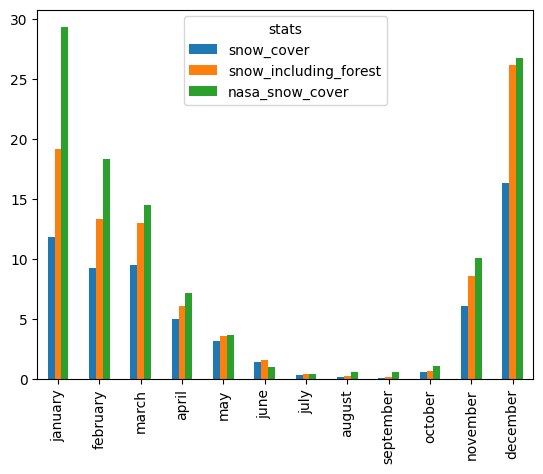

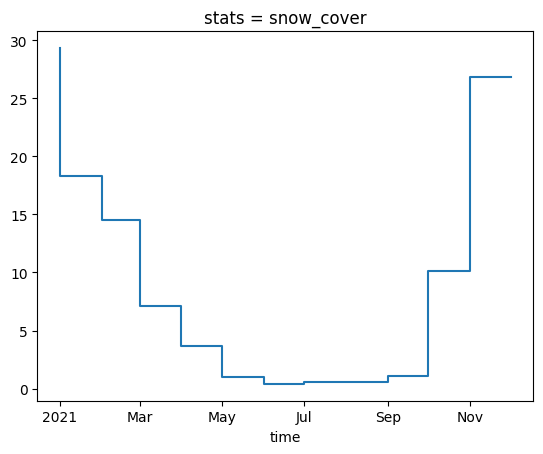

In [24]:
da.sel(stats='snow_cover').plot.step()

(array([5., 1., 1., 1., 1., 0., 1., 0., 0., 2.]),
 array([ 0.40229078,  3.2948231 ,  6.18735543,  9.07988775, 11.97242008,
        14.8649524 , 17.75748472, 20.65001705, 23.54254937, 26.4350817 ,
        29.32761402]),
 <BarContainer object of 10 artists>)

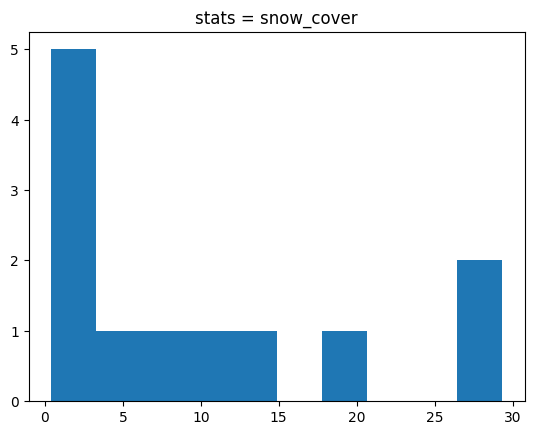

In [18]:
da.sel(stats='snow_cover').plot.hist()

In [22]:
winter_months_list = ['january', 'february',	'march', 'april','may','june','november', 'december']
meteofrance_winter_stats = meteofrance_year_statistics[winter_months_list]
nasa_winter_stats = nasa_year_statistics[winter_months_list]
total_surface = 60062.0

# Cloud cover mean
print(f'MeteoFrance Clouds % excluding summer (july - october): ',meteofrance_winter_stats.loc['clouds'].mean())
print(f'NASA Clouds % excluding summer (july - october): ',nasa_winter_stats.loc['clouds'].mean())

# Snow cover 
print(f'MeteoFrance snow covered % excluding summer (july - october): ', meteofrance_winter_stats.loc['snow_cover'].mean())
print(f'NASA snow covered % excluding summer (july - october): ', nasa_winter_stats.loc['snow_cover'].mean())

# Snow cover including forest
print(f'MeteoFrance snow covered % including forest excluding summer (july - october): ', meteofrance_winter_stats.loc['snow_cover'].mean() + meteofrance_winter_stats.loc['forest_with_snow'].mean())
print(f'NASA snow covered % including forest excluding summer (july - october): ', nasa_winter_stats.loc['snow_cover'].mean()) 


# Land including forest
print(f'MeteoFrance snow covered % including forest excluding summer (july - october): ', meteofrance_winter_stats.loc['no_snow'].mean() + meteofrance_winter_stats.loc['forest_without_snow'].mean())
print(f'NASA snow covered % including forest excluding summer (july - october): ', nasa_winter_stats.loc['no_snow'].mean()) 

MeteoFrance Clouds % excluding summer (july - october):  72.78001305918676
NASA Clouds % excluding summer (july - october):  59.95702190764739
MeteoFrance snow covered % excluding summer (july - october):  7.285041571392255
NASA snow covered % excluding summer (july - october):  12.54679039676628
MeteoFrance snow covered % including forest excluding summer (july - october):  10.486467959074243
NASA snow covered % including forest excluding summer (july - october):  12.54679039676628
MeteoFrance snow covered % including forest excluding summer (july - october):  16.592965660028703
NASA snow covered % including forest excluding summer (july - october):  27.408302379258444


In [18]:
ls ../data/vectorial/massifs_WGS84/massifs_WGS84/

alpes.geojson                     massifs_WGS84_merged_cleaned_simplified.qmd
massifs_mask_eofr62.tiff          massifs_WGS84_merged.geojson
massifs_mask_v10_epsg4326.tiff    massifs_WGS84_merged_simplified.geojson
massifs_WGS84.cpg*                massifs_WGS84.prj*
massifs_WGS84.dbf*                massifs_WGS84.qmd
massifs_WGS84.geojson             massifs_WGS84.shp*
massifs_WGS84_merged_cleaned.qmd  massifs_WGS84.shx*


In [20]:
import geopandas as gpd

gpd.read_file('../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_WGS84.geojson')['superficie'].sum()

np.float64(60062.0)

In [6]:
import rasterio
import xarray as xr
import numpy as np
test_da = xr.open_dataset(meteofrance_time_series_path).data_vars['snow_cover'].groupby('time.month')[1]
r = rasterio.open('../data/vectorial/massifs_WGS84/massifs_WGS84/massifs_mask_eofr62.tiff')
masked = test_da.where(r.read(1)).where(test_da != 230)

In [168]:
ls ../data/vectorial/massifs_WGS84/massifs_WGS84/

alpes.geojson                     massifs_WGS84_merged_cleaned_simplified.qmd
massifs_mask_eofr62.tiff          massifs_WGS84_merged.geojson
massifs_mask_v10_epsg3246.tiff    massifs_WGS84_merged_simplified.geojson
massifs_WGS84.cpg*                massifs_WGS84.prj*
massifs_WGS84.dbf*                massifs_WGS84.qmd
massifs_WGS84.geojson             massifs_WGS84.shp*
massifs_WGS84_merged_cleaned.qmd  massifs_WGS84.shx*


In [11]:
# Old statistics 2023 showed to Simon...it's the union of NASA h18v04 and meteofrance footprints 

meteofrance_statistics_calculator = SnowCoverProductStatistics(xr.open_dataset(meteofrance_time_series_name))
print('MeteoFrance')
meteofrance_statistics_calculator.year_statistics()


MeteoFrance
                     january  february  march  april    may   june   july  \
masked                54.980    48.806 52.941 53.989 53.397 51.595 45.195   
nodata                35.608    33.585 35.103 33.681 31.900 32.655 35.838   
no_snow_land           3.114     7.248  4.379  4.957  5.683  5.889  6.837   
water                  2.638     2.986  3.799  4.298  5.361  5.390  7.475   
forest_with_snow       0.593     0.862  0.232  0.087  0.040  0.015  0.002   
forest_without_snow    1.821     4.725  2.798  2.597  3.335  4.297  4.612   
snow_covered           1.244     1.787  0.747  0.391  0.283  0.159  0.041   
n_images              77.000    70.000 78.000 74.000 74.000 73.000 76.000   

                     august  september  october  november  december  
masked               46.563     42.829   48.263    51.740    53.114  
nodata               33.076     33.241   36.209    35.079    33.508  
no_snow_land          7.807     11.541    7.179     5.436     5.620  
water         

In [12]:
nasa_statistics_calculator = SnowCoverProductStatistics(nasa_ds_cropped,masked=np.nan,water=(237,220))
print('NASA')
nasa_statistics_calculator.print_year_statistics()

NASA
                     january  february  march  april    may   june   july  \
masked                59.211    38.872 53.653 53.489 47.253 36.562 37.701   
nodata                 0.000     0.000  0.000  0.000  0.000  0.000  0.000   
no_snow_land          15.398    35.710 23.289 24.507 31.544 42.525 41.603   
water                 20.380    20.535 20.415 20.414 20.464 20.575 20.553   
forest_with_snow       0.000     0.000  0.000  0.000  0.000  0.000  0.000   
forest_without_snow    0.000     0.000  0.000  0.000  0.000  0.000  0.000   
snow_covered           5.010     4.883  2.643  1.591  0.739  0.338  0.143   
n_images              62.000    56.000 62.000 60.000 62.000 60.000 60.000   

                     august  september  october  november  december  
masked               39.110     30.253   48.310    54.083    55.555  
nodata                0.000      0.000    0.000     0.000     0.000  
no_snow_land         40.206     48.969   30.832    22.524    19.955  
water                

In [3]:
nasa_time_series = xr.open_dataset(Path(time_series_folder, nasa_time_series_name))
nasa_time_series = nasa_time_series.rio.write_crs(nasa_time_series.data_vars['spatial_ref'].attrs['spatial_ref'])
new_nasa=nasa_time_series
meteofrance_time_series = xr.open_dataset(Path(time_series_folder, meteofrance_time_series_name))

Different results for the following two techniques

In [15]:
# Reproject THEN resample
reprojected_nasa = nasa_time_series.rio.reproject(meteofrance_time_series.data_vars['spatial_ref'].attrs['spatial_ref'])
#reprojected_nasa.to_netcdf(Path(time_series_folder, '2017_01_nasa_time_series_reprojected.nc'), encoding={'snow_cover':{'zlib': True}, 'time': {'calendar': 'gregorian', 'units': 'days since 2016-10-01'}})
#resampled_nasa = reprojected_nasa.rio.reproject(reprojected_nasa.coords['spatial_ref'].attrs['spatial_ref'], shape=(meteofrance_time_series.sizes['lat'],meteofrance_time_series.sizes['lon']) , resampling = Resampling.bilinear)
#resampled_nasa.to_netcdf(Path(time_series_folder, '2017_01_nasa_time_series_reprojected_then_resampled.nc'), encoding={'snow_cover':{'zlib': True}, 'time': {'calendar': 'gregorian', 'units': 'days since 2016-10-01'}})
new_nasa = reprojected_nasa

: 

In [ ]:
reprojected_nasa.to_netcdf(Path(time_series_folder, '2023_nasa_time_series_fsc_reprojected.nc'),encoding={'snow_cover':{'zlib': True}, 'time': {'calendar': 'gregorian', 'units': 'days since 2016-10-01'}})

In [ ]:
# Reproject AND resample at once
# rr_nasa = nasa_time_series.rio.reproject(meteofrance_time_series.data_vars['spatial_ref'].attrs['spatial_ref'], shape=(meteofrance_time_series.sizes['lat'],meteofrance_time_series.sizes['lon']) , resampling = Resampling.bilinear)
# rr_nasa.to_netcdf(Path(time_series_folder, '2017_01_nasa_time_series_rr.nc'), encoding={'snow_cover':{'zlib': True}, 'time': {'calendar': 'gregorian', 'units': 'days since 2016-10-01'}})

In [4]:
lat_min = max(meteofrance_time_series.coords['lat'].min(), new_nasa.coords['y'].min())
lat_max = min(meteofrance_time_series.coords['lat'].max(), new_nasa.coords['y'].max())
lon_min = max(meteofrance_time_series.coords['lon'].min(), new_nasa.coords['x'].min())
lon_max = min(meteofrance_time_series.coords['lon'].max(), new_nasa.coords['x'].max())
lat_min, lat_max, lon_min, lon_max = [coord.values for coord in (lat_min, lat_max, lon_min, lon_max )]

In [5]:
meteofrance_ds_cropped = meteofrance_time_series.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
nasa_ds_cropped = new_nasa.sel(y=slice(lat_max, lat_min), x=slice(lon_min, lon_max))
nasa_ds_cropped=nasa_ds_cropped.rename({"x": "lon", "y": "lat"})